# Import package

In [1]:
import os
import pandas as pd
import numpy as np
from root_numpy import root2array 
#----------------------------------------------
from root_numpy import root2array, stretch
from pyjet import cluster
from pyjet.testdata import get_event
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import glob
import matplotlib.cm as cm
from scipy.stats import binned_statistic_2d
from matplotlib.colors import LogNorm
#---------------------------------
import h5py

Welcome to JupyROOT 6.20/04


$ pip3 install tqdm
$ pip3 install pyjet
$ pip3 install scipy
$ pip3 install h5py

$ cd <path_to_your_root_file>
$　root XXX.root
[root] _file0->ls()
[root] Delphes->MakeClass()

In [64]:
events = root2array(root_file, "Delphes;1", branches=[
        "Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.E"], start=0, stop=1)
# event = jet_trimmer(event=events[0], R0=1.2, R1=0.2, pt_cut=0.03)
flattened_event = stretch(events.reshape(-1))
sequence = cluster(flattened_event, R=1.2, p=-1)
jets = sequence.inclusive_jets(ptmin=200)
subjets = cluster(jets[0].constituents_array(), R=0.2, p=1)

In [65]:
subjets.inclusive_jets() 

[PseudoJet(pt=595.025, eta=-1.854, phi=-2.485, mass=1949.907),
 PseudoJet(pt=11.878, eta=-1.000, phi=-2.586, mass=18.362),
 PseudoJet(pt=10.031, eta=-0.664, phi=-2.473, mass=12.341),
 PseudoJet(pt=6.833, eta=-2.388, phi=-2.854, mass=38.943),
 PseudoJet(pt=5.318, eta=-3.070, phi=2.808, mass=57.814),
 PseudoJet(pt=3.096, eta=-3.480, phi=-1.569, mass=50.290),
 PseudoJet(pt=2.572, eta=-4.422, phi=-1.358, mass=107.099),
 PseudoJet(pt=2.069, eta=-1.855, phi=3.087, mass=6.845),
 PseudoJet(pt=1.913, eta=-4.245, phi=-2.147, mass=66.729),
 PseudoJet(pt=1.296, eta=-4.721, phi=-1.861, mass=72.775),
 PseudoJet(pt=1.213, eta=-0.388, phi=-2.188, mass=1.327)]

In [77]:
jets[0]

PseudoJet(pt=634.745, eta=-1.987, phi=-2.490, mass=2400.177)

# Define function to trace particle decay

In [71]:
## Taylor's root to jet image code
def root_2_jets(root_file):
    # Takes root_file as produces a jet-image
    events = root2array(root_file, "Delphes;1", branches=[
        "Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.E"])

    jet_images = []
    for ix, event in enumerate(tqdm(events)):
        # create trimmed jet event (also centered and rotated)
        event = jet_trimmer(event=event, R0=0.8, R1=0.4, pt_cut=0.03) #paper setting
        

        # pixelize the trimmed jet
        jet_image = pixelize(event)

        # include jet-image as long as it isn't blank
        # blank jets occur only if the event fails a cut
        # during trimming
        if np.sum(jet_image) != 0:
            jet_images.append(jet_image)
    return jet_images
def struc2arr(x):
    # pyjet outputs a structured array. This converts
    # the 4 component structured array into a simple
    # 4xN numpy array
    x = x.view((float, len(x.dtype.names)))
    return x


def rotate(x, y, a):
    xp = x * np.cos(a) - y * np.sin(a)
    yp = x * np.sin(a) + y * np.cos(a)
    return xp, yp


def jet_trimmer(event, R0, R1, pt_cut):
    # R0 = Clustering radius for the main jets
    # R1 = Clustering radius for the subjets in the primary jet
    # pt_cut = Threshold for subjets (relative to the primary jet it's a subjet of)

    trim_pt, trim_eta, trim_phi, trim_mass = [], [], [], []
    flattened_event = stretch(event.reshape(-1))
    sequence = cluster(flattened_event, R=R0, p=-1)

    # Main jets
    jets = sequence.inclusive_jets(ptmin=400)

    # In case we are missing a leading jet, break early
    if len(jets) == 0:
        return np.zeros(1), np.zeros(1), np.zeros(1), np.zeros(1)

    # Take just the leading jet
    jet0 = jets[0]

    # Define a cut threshold that the subjets have to meet (i.e. 5% of the original jet pT)
    jet0_max = jet0.pt
    jet0_cut = jet0_max*pt_cut

    # Grab the subjets by clustering with R1
    subjets = cluster(jet0.constituents_array(), R=R1, p=1)
    subjet_array = subjets.inclusive_jets()

    # Require at least 2 subjets. Otherwise, break early
    if len(subjet_array) <= 1:
        return np.zeros(1), np.zeros(1), np.zeros(1), np.zeros(1)

    for subjet in subjet_array:
        if subjet.pt < jet0_cut:
            # subjet doesn't meet the percentage cut on the original jet pT
            pass
        else:
            # Get the subjets pt, eta, phi constituents
            subjet_data = subjet.constituents_array()
            subjet_data = struc2arr(subjet_data)
            pT = subjet_data[:, 0]
            eta = subjet_data[:, 1]
            phi = subjet_data[:, 2]
            mass = subjet_data[:, 3]

            # Shift all data such that the leading subjet
            # is located at (eta,phi) = (0,0)
            eta -= subjet_array[0].eta
#             eta -= jet0.eta
            phi = np.array( [deltaPhi(i,subjet_array[0].phi) for i in phi])
#             phi = np.array( [deltaPhi(i,jet0.phi) for i in phi])
            

            # Rotate the jet image such that the second leading
            # jet is located at -pi/2
#             s1x, s1y = subjet_array[1].eta, subjet_array[1].phi
            s1x, s1y = subjet_array[1].eta - subjet_array[0].eta, deltaPhi(subjet_array[1].phi,subjet_array[0].phi)
#             s1x, s1y = subjet_array[1].eta - jet0.eta, deltaPhi(subjet_array[1].phi, jet0.phi)
            

            theta = np.arctan2(s1y, s1x)
            if theta < 0.0:
                theta += 2 * np.pi
            eta, phi = rotate(eta, phi, np.pi - theta)

            # Collect the trimmed subjet constituents
            trim_pt.append(pT)
            trim_eta.append(eta)
            trim_phi.append(phi)
            trim_mass.append(mass)
    return np.concatenate(trim_pt), np.concatenate(trim_eta), np.concatenate(trim_phi), np.concatenate(trim_mass)


def pixelize(event):
    pt, eta, phi = event[0], event[1], event[2]

    # Define the binning for the complete calorimeter
#     bins = np.arange(-1.2, 1.2, 0.1)
    bins = 64
    ranges = np.array([[-4,4],[-4,4]])

    # Sum energy deposits in each bin
    digitized = binned_statistic_2d(eta, phi, pt*0+1, statistic="sum", bins=bins, range= ranges)
#     digitized = binned_statistic_2d(eta, phi, pt, statistic="sum", bins=bins)
    
    jet_image = digitized.statistic
    return jet_image
#-----------------------------------------------------------------------------------------------------------
def find_decayratio(event,n, mode = 'daughter'):
    d1, d2 = -1, -1
    d0 = -1
    ID = 4900101 #Xd PID
    for j in  range(len(event[n][0])):
        if(event[n][5][j]==ID)&(event[n][0][j]==23): #23 : hardest outgoing particles
            d1 = event[n][_D1][j]
            d2 = event[n][_D2][j]
            while((event[n][_PID][d1]==ID)or(event[n][5][d2]==ID) ):
                if(event[n][_PID][d1]==ID):
                    d0 = d1
                    d1 = event[n][_D1][d0]
                    d2 = event[n][_D2][d0]
                    if(event[n][_PID][d2]==ID):
                        d0 = d2
                        d1 = event[n][_D1][d0]
                        d2 = event[n][_D2][d0]
                        
    if mode=='daughter':
        return d1, d2
    if mode=='id':
        return event[n][5][d1], event[n][5][d2]
    
def find_subdecayratio(event, n, j, ID=4900111): 
    d1, d2 = -1, -1
    d0 = -1
    d1 = event[n][_D1][j]
    d2 = event[n][_D2][j]
    if((abs(event[n][_PID][d1])!=ID)&(abs(event[n][_PID][d2])!=ID)):
        d1=0
        d2=0
        return d1, d2
    else:
        while((abs(event[n][_PID][d1])==ID)or(abs(event[n][_PID][d2])==ID) ):
            if(abs(event[n][_PID][d1])==ID):
                d0 = d1
                d1 = event[n][_D1][d0]
                d2 = event[n][_D2][d0]
            if(abs(event[n][_PID][d2])==ID):
                d0 = d2
                d1 = event[n][_D1][d0]
                d2 = event[n][_D2][d0]
        return event[n][_PID][d1], event[n][_PID][d2]
def find_daughterid(event, n, j, ID=4900111):
    sid = event[n][_PID][j]
    if(sid!=ID):
        return 0, 0
    else:
        d1 = event[n][_D1][j]
        d2 = event[n][_D2][j]
        return event[n][_PID][d1], event[n][_PID][d2]

def deltaPhi(phi1,phi2):
    x = phi1-phi2
    while x>= np.pi: x -= np.pi*2.
    while x< -np.pi: x += np.pi*2.
    return x        

# CMS card Setting
module FastJetFinder FatJetFinder {
  set InputArray EFlowMerger/eflow

  set OutputArray jets

<!--   # algorithm: 1 CDFJetClu, 2 MidPoint, 3 SIScone, 4 kt, 5 Cambridge/Aachen, 6 antikt -->
  set JetAlgorithm 6
  set ParameterR 0.8

  set ComputeNsubjettiness 1
  set Beta 1.0
  set AxisMode 4

  set ComputeTrimming 1
  set RTrim 0.2
  set PtFracTrim 0.05

  set ComputePruning 1
  set ZcutPrun 0.1
  set RcutPrun 0.5
  set RPrun 0.8

  set ComputeSoftDrop 1
  set BetaSoftDrop 0.0
  set SymmetryCutSoftDrop 0.1
  set R0SoftDrop 0.8

  set JetPTMin 200.0
}


# Load root file

In [72]:
#Need to use CMS card to search Fatjet
# root_file = "./SVJ_pythia/QCD_Dijet/ppjj.root" # This is test data: p p -> q q~ (q= u d s)
root_file = "./SVJ_pythia/QCD_Dijet/ppjj_Altas.root" # This is test data: p p -> j j (j=g u d s u~ d~ s~)
# root_file2 = "./SVJ_pythia/Z1500/delphes_nolhe_Z1500_rinv_03.root" #rinv = 0.3 SVJ
root_file2 = "./SVJ_pythia/Nowidth/Z2000/delphes_nolhe_Z2000_rinv_04.root" #rinv = 0.3 SVJ
jet_im2 = root_2_jets(root_file2)
jet_im = root_2_jets(root_file)

100%|██████████| 20000/20000 [00:19<00:00, 1022.23it/s]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


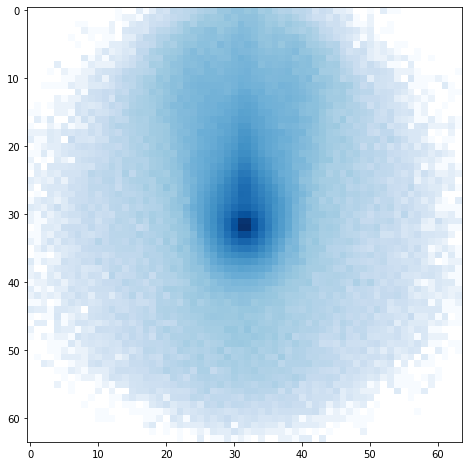

In [75]:
jet_im= np.array(jet_im)
plt.figure(figsize=(8,8))
X = np.sum(jet_im,axis=0)
plt.imshow(np.log(X), cmap='Blues', label = 'QCD')
# plt.imshow(X/20000, cmap='Blues', label = 'QCD')

plt.savefig("./jet_image_QCD_08.png")
plt.show()


In [69]:
jet_im.shape

(18884, 64, 64)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


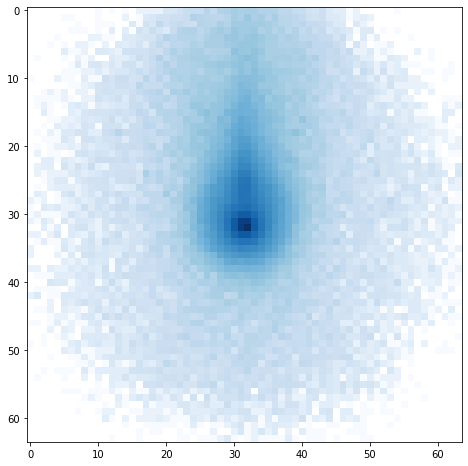

In [76]:
#SVJ 
jet_im2= np.array(jet_im2)
plt.figure(figsize=(8,8))
X2 = np.sum(jet_im2,axis=0)
plt.imshow(np.log(X2), cmap='Blues', label = 'SVJ')
# plt.imshow(X2/20000, cmap='Blues', label = 'SVJ')
plt.savefig("./jet_image_SVJ_Z2000_rinv_04_08.png")
plt.show()

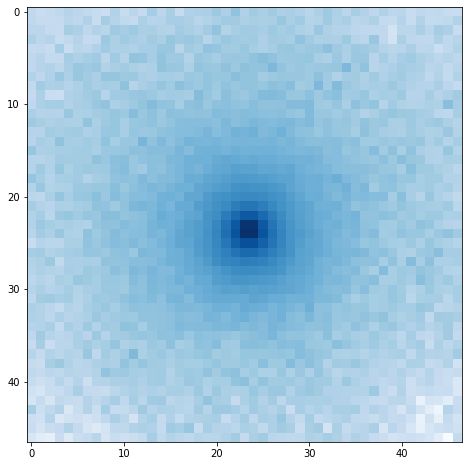

In [97]:
jet_im= np.array(jet_im)
plt.figure(figsize=(8,8))
X = np.sum(jet_im,axis=0)
plt.imshow(np.log(X), cmap='Blues', label = 'QCD')
# plt.savefig("./jet_image_QCD.png")
plt.show()


# Show truth record

In [31]:
# Particle status in Pythia8: http://home.thep.lu.se/~torbjorn/pythia81html/ParticleProperties.html
event = root2array(root_file, "Delphes;1", branches=[
"Particle.Status", "Particle.M1", "Particle.M2", "Particle.D1", "Particle.D2",
"Particle.PID", "Particle.PT",
"Particle.Eta","Particle.Phi", "Particle.Mass"], start=0, stop=1, step=None)
# in this example I set 
_Status, _M1, _M2, _D1, _D2, _PID, _PT, _Eta, _Phi, _Mass = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
Labels = ["Status", "M1", "M2", "D1", "D2", "PID", "PT", "Eta", "Phi", "Mass"]

print("Index", "\t","Status", "\t","M1" "\t","M2" ,"\t","D1", "\t","D2", "\t","PID", "\t\t","PT" "\t","Eta", "\t\t","Phi", "\t\t","Mass")
for j in range(len(event[0][0])):  
    print(j, "\t", event[0][_Status][j],  "\t\t", event[0][_M1][j], "\t", event[0][_M2][j], "\t", event[0][_D1][j], "\t", 
          event[0][_D2][j],  "\t", str(event[0][_PID][j]).ljust(12, ' '), "\t", round(event[0][_PT][j],0),  "\t",
          str(round(event[0][_Eta][j],2)).ljust(12, ' ') , "\t",str(round(event[0][_Phi][j],3)).ljust(12, ' '),  "\t",round(event[0][_Mass][j],3)) 
 

# Trace certain particle ID untile it "decay" (daughter1!=daughter2)

In [6]:
n=0
ID=989
N = []
for j in  range(len(event[n][0])):
    if(event[n][_PID][j]==ID): #23 : hardest outgoing particles
        print("Self index in event",j)
        m1 = event[n][_M1][j]
        m2 = event[n][_M2][j]
        print("Mother:",m1,m2)
        if (m1==m2):
            print("Mother_id:", event[n][_PID][m1], "nan\n")
        else:
            print("Mother_id:", event[n][_PID][m1], event[n][_PID][m2],"\n")
        d1 = event[n][_D1][j]
        d2 = event[n][_D2][j]
        prevent = 0
        while(d1==d2): 
            d0 = d1
            if(d1==-1):
                print("stable particles\n\n")
                break
            if(prevent >= 100):
                print("infinite loop!")
                prevent=0
                break
            d1 = event[n][_D1][d1]
            d2 = event[n][_D2][d2]
            if(d1!=d2):
                N.append(d0)
            prevent= prevent+1
        if(d1!=-1):
            print("Daughter", d1, d2)
            print("Daughter_id", event[n][_PID][d1], event[n][_PID][d2])
            m1, m2 = event[n][_M1][d1], event[n][_M2][d1]
            print("Daughter1_parents", m1, m2)
            if(m1==m2):
                print("Daughter1_parents_id", event[n][_PID][m1], "nan") 
            else:
                print("Daughter1_parents_id", event[n][_PID][m1], event[n][_PID][m2])
            m1, m2 = event[n][_M1][d2], event[n][_M2][d2]
            print("Daughter2_parents", m1, m2)
            if(m1==m2): 
                print("Daughter2_parents_id", event[n][_PID][m1], "nan","\n")
            else:
                print("Daughter2_parents_id", event[n][_PID][m1], event[n][5][m2],"\n")

# Load weights and jets

In [36]:
nevn=20000 # number of event you generate in madgraph
W =  root2array(root_file, "Delphes;1", branches=["Event.Weight"], start=0, stop=20000, step=None) #weight for each event
jet = root2array(root_file, "Delphes;1", branches=["Jet.PT", "Jet.Eta", "Jet.Phi", "Jet.Mass"], start=0, stop=20000, step=None)
W = [i[0][0] for i in W] #just reset the data structure to convenienc
# root_file2 = "./SVJ_pythia/Z1500/delphes_nolhe_Z1500_rinv_0.root"
# jet2 = root2array(root_file2, "Delphes;1", branches=["Jet.PT", "Jet.Eta", "Jet.Phi", "Jet.Mass"], start=0, stop=20000, step=None)
# W2 =  root2array(root_file2, "Delphes;1", branches=["Event.Weight"], start=0, stop=20000, step=None)
# W2 = [i[0][0] for i in W2]
#We set
_JPT, _JEta, _JPhi, _JMass = 0, 1, 2, 3

# Define invariant mass function

In [20]:
def mass_inv(jet):
#    ["FatJet.PT", "FatJet.Eta", "FatJet.Phi", "FatJet.Mass"] 
# formula https://en.wikipedia.org/wiki/Invariant_mass#As_defined_in_particle_physics
    M_inv = 2*jet[_JPT][0]*jet[_JPT][1]*(np.cosh(jet[_JEta][0]-jet[_JEta][1])-np.cos(jet[_JPhi][0]-jet[_JPhi][1]))
    return M_inv**0.5
    

# Jet selection and fill up with invariant mass

In [37]:
m_inv = []
Wc = []
for i in range(len(jet)):
    if jet[i][0].shape[0]<2: #at least two jet
        continue
    if jet[i][_JPT][0]<440: # leading jet pt >= 440 Gev
        continue
    if jet[i][_JPT][1]<60: #sub-leading jet pt >= 60 Gev
        continue
#     if abs(jet[i][_JEta][0]-jet[i][_JEta][1])>=1.2:
#         continue
    m_inv.append(mass_inv(jet[i]))
    Wc.append(W[i])
# m_inv2 = []
# Wc2 = []
# for i in range(len(jet2)):
#     if jet2[i][0].shape[0]<2:
#         continue
#     if jet2[i][0][0]<440:
#         continue
#     if jet2[i][0][1]<60:
#         continue
#     if abs(jet2[i][1][0]-jet2[i][1][1])>=1.2:
#         continue
#     m_inv2.append(mass_inv(jet2[i]))
#     Wc2.append(W2[i])

# Calculate the cross section in root

In [38]:
Xection = sum(W)/nevn
Xection_with_selection = sum(Wc)/nevn
Lumi = 37 #Luminosity fb^-1
expected_yield = (Xection)*Lumi*1000 #expected yield
expected_yield_c = (Xection_with_selection)*Lumi*1000 #expected yield
print("Cross section(pb) \t Cross section with selection(pb) \t Expected yield (tatal)\t Expected yield for Selection")
print(Xection,"\t\t",Xection_with_selection,"\t\t\t",expected_yield,'\t',expected_yield_c)

Cross section(pb) 	 Cross section with selection(pb) 	 Expected yield (tatal)	 Expected yield for Selection
976.8411865234375 		 832.1710067993164 			 36143123.90136719 	 30790327.251574706


# Plot

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


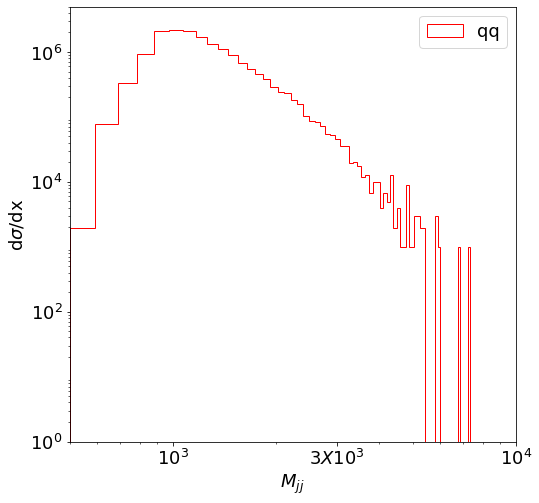

In [39]:
bins = 100
fs=18 # front size
tagsize = 18 # label tag size ((\blue block) W \n (\orange block) QCD )
plt.figure(figsize=(8,8)) # plotsize
x1, x2 = 500, 10000

bisize = np.linspace(500,10000,101)


# plt.hist(m_inv2 ,bins=bins, histtype='step',  range=[x1, x2], weights= np.array(Wc2),
#          label='rinv = 0.0, ${M_{Z}}$=1.5 TeV')
plt.hist(m_inv ,bins=bins, histtype='step', color='r', range=[x1, x2], weights= np.array(Wc),
         label='qq')

  
plt.legend(prop={'size': tagsize}) # plot label tag
plt.yscale('log')
plt.xscale('log')
plt.xlabel('${M_{jj}}$' , fontsize=fs)  # plot x-axis label
plt.ylabel("d${\sigma}$/dx", fontsize=fs)  # plot y-axis label $\u03C3^{-1}$
plt.ylim((0,5000000))
plt.xlim((x1,x2))
plt.xticks([1000,3000,10000], ['${10^3}$', '3${X}$${10^{3}}$','${10^{4}}$' ],fontsize=fs)   # set x-ticks size
plt.yticks([1,100,10000,1000000],fontsize=fs)   # set y-ticks size 
# plt.savefig("./invariant_mass_JET_SVJ_Z1500.png")  #save figure as png  
plt.show() 

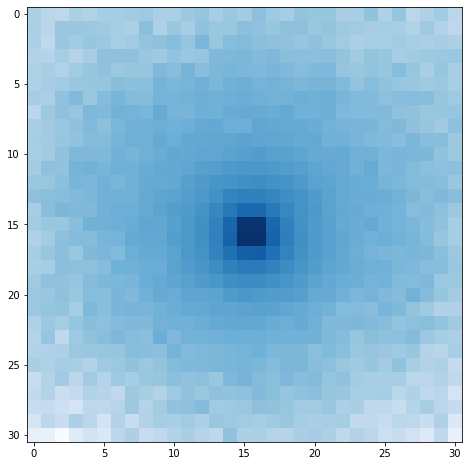

In [68]:
jet_im= np.array(jet_im)
plt.figure(figsize=(8,8))
X = np.sum(jet_im,axis=0)
plt.imshow(np.log(X), cmap='Blues', label = 'QCD')
# plt.savefig("./jet_image_QCD.png")
plt.show()


In [61]:
jet_im[0]

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
  

# Save jet image as h5

In [14]:
hf = h5py.File('./QCD_Dijet_ppqq.h5', 'w')
hf.create_dataset('dataset_1', data=jet_im)
hf.close()